In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import init_printing
init_printing()
%matplotlib inline

# Set up an initial configuration in REBOUND

Let's set up a REBOUND simulation with three planets around a solar-mass star

* Innermost planet at a period of 1 year
* All planets have $m=10^{-4} M_\odot$, or $\approx2$x the mass of Neptune
* Eccentricities $\sim 10^{-2}$
* we start bodies at pericenter, and align the pericenters (pomega) in different directions

In [2]:
import rebound
def get_sim():
    sim = rebound.Simulation()
    sim.add(m=1)
 
    sim.G = 4*np.pi*np.pi
    mass=1e-4
    
    sim.add(m=mass,P=1, e=0.01)
    sim.add(m=mass,P=3/2,e=0.03,pomega=np.pi)
    sim.add(m=mass,P=10.1,e=0.02,pomega=0.5*np.pi)
    
    sim.dt = sim.particles[1].P / 30.
    sim.integrator='whfast'
    return sim 

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: cm


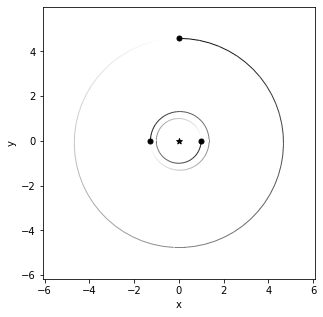

In [3]:
sim=get_sim()
fig = rebound.OrbitPlot(sim)

# Make a celmech model

Import Poincare variable functions from the celmech package

In [4]:
from celmech import Poincare, PoincareHamiltonian

Initialize model directly from the REBOUND simulation

In [5]:
sim=get_sim()
poincare_variables = Poincare.from_Simulation(sim)

A 'Poincare' object stores a set of particles with Poincare canonical coordinates:
\begin{align}
\Lambda_i = \mu_i\sqrt{G M_* a_i} &;& \lambda_i \\
X_i = \sqrt{2\Gamma_i}\cos(\gamma_i) &;& Y_i=\sqrt{2\Gamma_i}\sin(\gamma_i)
\end{align}
where 
\begin{align}
\Gamma_i = \Lambda_i(1-\sqrt{1-e_i^2}) &;& \gamma_i =-\varpi_i.
\end{align}
By default, celmech uses canonical heliocentric coordinates in a center of mass frame (e.g., Laskar \& Robutel 1995), in which case the appropriate masses are
\begin{align}
\mu_i = \frac{m_0 m_i}{m_0 + m_i} &;& M_i = m_0 + m_i \\
\end{align}

Now construct a Hamiltonian model with the Poincare varaibles:

In [6]:
Hp = PoincareHamiltonian(poincare_variables)

The 'Hamlitonian' object keeps track of a symbolic Hamiltonian. By default 𝑁 distinct Keplerian terms are included.

In [7]:
Hp.H

   2   2   3    2   2   3    2   2   3
  G ⋅M₃ ⋅μ₃    G ⋅M₂ ⋅μ₂    G ⋅M₁ ⋅μ₁ 
- ────────── - ────────── - ──────────
        2            2            2   
    2⋅Λ₃         2⋅Λ₂         2⋅Λ₁    

Now let's add the leading order terms for the 3:2 MMR between the inner two planets

In [8]:
Hp.add_MMR_terms(p=3, q=1, indexIn=1, indexOut=2)

In [9]:
Hp.df

<IPython.core.display.Math object>

In [10]:
%%time
Nout = 1000
Norbs = 700
e1, Ne1 = np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0, Norbs*Hp.particles[1].P, Nout)
for i, time in enumerate(times):
    Hp.integrate(time)
    sim.integrate(time)
    e1[i] = Hp.particles[1].e
    Ne1[i] = sim.particles[1].e

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1182: UserWarning: dop853: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))


CPU times: user 1.6 s, sys: 7.42 ms, total: 1.61 s
Wall time: 1.6 s


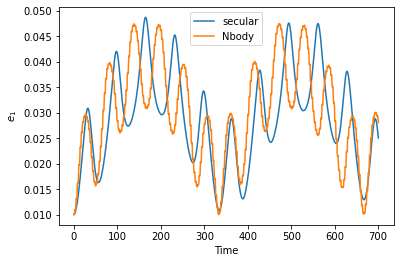

In [11]:
fig, ax = plt.subplots()
ax.plot(times, e1, label='secular')
ax.plot(times, Ne1, label='Nbody')
ax.set_xlabel('Time')
ax.set_ylabel('$e_1$')
ax.legend()

# Going to Higher Order

In [12]:
sim=get_sim()
poincare_variables = Poincare.from_Simulation(sim)
Hp = PoincareHamiltonian(poincare_variables)

Hp.add_MMR_terms(p=3, q=1, max_order=2, indexIn=1, indexOut=2)

for i1 in range(1,sim.N):
    for i2 in range(i1+1,sim.N):# get all combinations of planets
        print('Adding secular terms for planets {0} and {1}'.format(i1, i2))
        Hp.add_secular_terms(max_order=2, indexIn=i1, indexOut=i2)

Adding secular terms for planets 1 and 2
Adding secular terms for planets 1 and 3
Adding secular terms for planets 2 and 3


In [13]:
Hp.df

<IPython.core.display.Math object>

In [16]:
%%time
e1 = np.zeros(Nout)
times = np.linspace(0, Norbs*Hp.particles[1].P, Nout)
for i, time in enumerate(times):
    Hp.integrate(time)
    e1[i] = Hp.particles[1].e

CPU times: user 7.7 s, sys: 28.9 ms, total: 7.73 s
Wall time: 7.7 s


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1182: UserWarning: dop853: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))


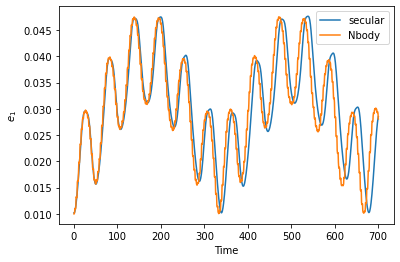

In [17]:
fig, ax = plt.subplots()
ax.plot(times, e1, label='secular')
ax.plot(times, Ne1, label='Nbody')
ax.set_xlabel('Time')
ax.set_ylabel('$e_1$')
ax.legend()

In [20]:
a = np.array([0,0,0])
(a != 0).any()

False